In [1]:
import crowdsource

In [2]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

In [3]:
from astropy.io import fits

In [4]:
from crowdsource import crowdsource_base
from crowdsource.crowdsource_base import fit_im, psfmod

In [5]:
from astroquery.svo_fps import SvoFps

In [6]:
cd /orange/adamginsburg/jwst/brick/images

/blue/adamginsburg/adamginsburg/jwst/brick/images


In [7]:
fh = fits.open('last2022version/jw02221-o001_t001_nircam_clear-f410m_i2d.fits')
# how does this work on indiv snapshots?
fh = fits.open('/blue/adamginsburg/adamginsburg/jwst/brick/F410M/pipeline/jw02221001001_07101_00001_nrcalong_cal.fits')
im1 = fh
instrument = im1[0].header['INSTRUME']
telescope = im1[0].header['TELESCOP']
filt = im1[0].header['FILTER']

wavelength_table = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')
obsdate = im1[0].header['DATE-OBS']

In [8]:
# data = fh[1].data[1383:1883, 2344:2844]
# CANNOT use cutouts with new PSF model
data = fh[1].data

In [9]:
import os
os.environ['WEBBPSF_PATH'] = '/orange/adamginsburg/jwst/webbpsf-data/'
with open(os.path.expanduser('~/.mast_api_token'), 'r') as fh:
    os.environ['MAST_API_TOKEN'] = fh.read().strip()
import webbpsf

In [10]:
import webbpsf
nc = webbpsf.NIRCam()
nc.filter =  'F410M'
nc.load_wss_opd_by_date(f'{obsdate}T00:00:00')
psf_initial = nc.calc_psf(oversample=4, fov_pixels=31)     # returns an astropy.io.fits.HDUlist containing PSF and header


MAST OPD query around UTC: 2022-08-28T00:00:00.000
                        MJD: 59819.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022082702-NRCA3_FP1-1.fits
	Date (MJD):	 59817.7488
	Delta time:	 -1.2512 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022082902-NRCA3_FP1-1.fits
	Date (MJD):	 59819.7687
	Delta time:	 0.7687 days
User requested choosing OPD time closest in time to 2022-08-28T00:00:00.000, which is R2022082902-NRCA3_FP1-1.fits, delta time 0.769 days
INFO: MAST API token accepted, welcome Adam Ginsburg [astroquery.mast.auth]
Importing and format-converting OPD from /orange/adamginsburg/jwst/webbpsf-data/MAST_JWST_WSS_OPDs/R2022082902-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point


In [11]:
import numpy as np

In [12]:
nrc = webbpsf.NIRCam()
nrc.load_wss_opd_by_date(f'{obsdate}T00:00:00')
nrc.filter =  'F410M'
grid = nrc.psf_grid(num_psfs=16, all_detectors=False)


MAST OPD query around UTC: 2022-08-28T00:00:00.000
                        MJD: 59819.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022082702-NRCA3_FP1-1.fits
	Date (MJD):	 59817.7488
	Delta time:	 -1.2512 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022082902-NRCA3_FP1-1.fits
	Date (MJD):	 59819.7687
	Delta time:	 0.7687 days
User requested choosing OPD time closest in time to 2022-08-28T00:00:00.000, which is R2022082902-NRCA3_FP1-1.fits, delta time 0.769 days
Importing and format-converting OPD from /orange/adamginsburg/jwst/webbpsf-data/MAST_JWST_WSS_OPDs/R2022082902-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point

Running instrument: NIRCam, filter: F410M.  Detector list = ['NRCA5']
  Running detector: NRCA5
    Position 1/16: (0, 0) pixels
    Position 2/16: (0, 682) pixels
    Position 3/16: (0, 1365) pixels
    Position 4/16: (0, 2047) pixels
    Position 5/16: (682, 0) p

In [13]:
import copy
yy, xx = np.indices([31,31], dtype=float)
gridc = copy.deepcopy(grid)
gridc.x_0 = gridc.y_0 = 15.5
psf_model = crowdsource.psf.SimplePSF(stamp=gridc(xx,yy))

In [44]:
err = im1['ERR'].data
if 'WHT' in im1:
    wht = im1['WHT'].data
else:
    wht = 1

weight = err**-1
maxweight = np.percentile(weight[np.isfinite(weight)], 95)
minweight = np.percentile(weight[np.isfinite(weight)], 5)
badweight =  np.percentile(weight[np.isfinite(weight)], 1)
weight[err < 1e-5] = 0
#weight[(err == 0) | (wht == 0)] = np.nanmedian(weight)
weight[np.isnan(weight)] = 0
bad = np.isnan(weight) | (data == 0) | np.isnan(data) | (weight == 0) | (err == 0) | (wht == 0) | (data < 1e-5)

weight[weight > maxweight] = maxweight
weight[weight < minweight] = minweight
# it seems that crowdsource doesn't like zero weights
# may have caused broked f466n? weight[bad] = badweight
weight[bad] = minweight
# crowdsource explicitly handles weight=0, so this _should_ work.
weight[bad] = 0

/scratch/local/56668455/ipykernel_15247/1749953265.py:7: RuntimeWarning: divide by zero encountered in reciprocal
  weight = err**-1


In [45]:
results  = fit_im(data, psf_model, weight=weight, #np.ones_like(data)*5,
                                #psfderiv=np.gradient(-psf_initial[0].data),
                                nskyx=0, nskyy=0, refit_psf=False, verbose=True)
stars, modsky, skymsky, psf = results

Starting subregion iterations
Subregion iteration 0 starting; dt=0.008656501770019531
titer=0
Extension None, iteration  1, found  60461 sources;   77 close and 8302 faint sources removed.
Starting subregion iterations
Subregion iteration 0 starting; dt=0.001672983169555664


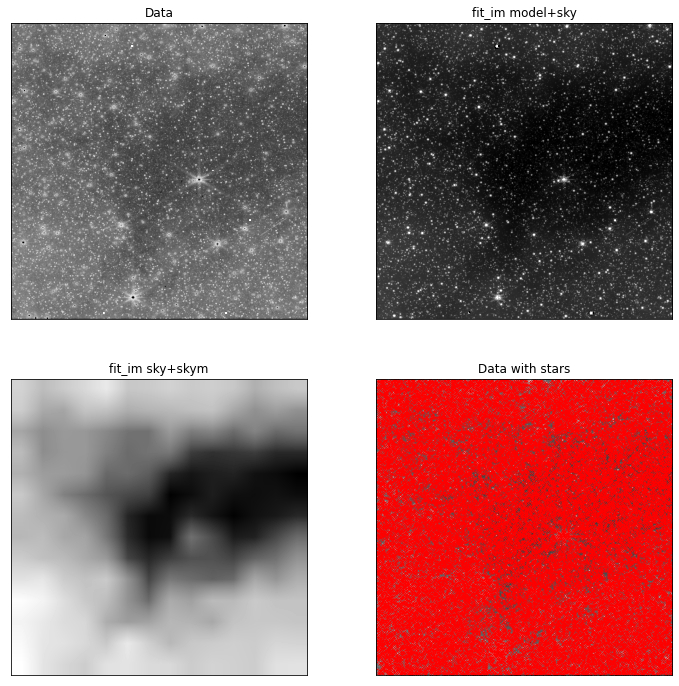

In [46]:
pl.figure(figsize=(12,12))
pl.subplot(2,2,1).imshow(data, norm=simple_norm(data, stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,2,2).imshow(modsky, norm=simple_norm(modsky, stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,2,3).imshow(skymsky, norm=simple_norm(skymsky, stretch='asinh'), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im sky+skym")
pl.subplot(2,2,4).imshow(data, norm=simple_norm(data, stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.subplot(2,2,4).scatter(stars['y'], stars['x'], marker='x', color='r', s=5, linewidth=0.5)
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");

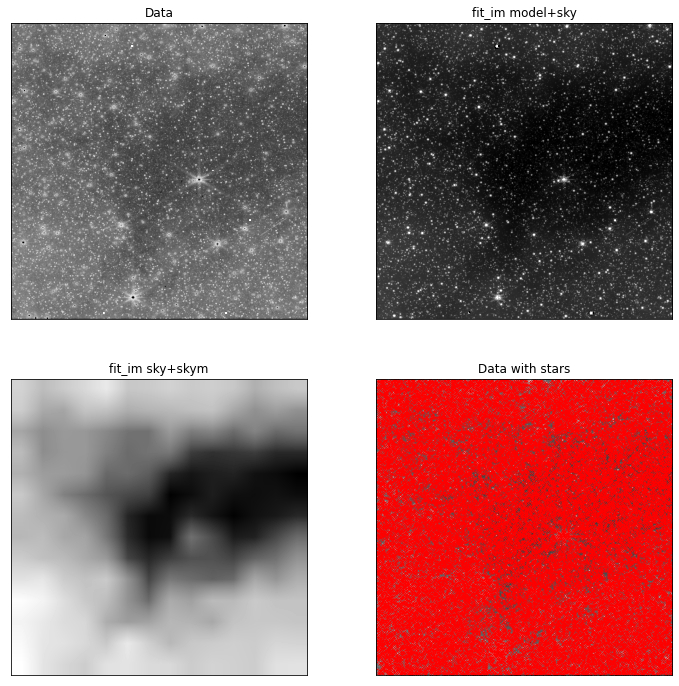

In [47]:
pl.figure(figsize=(12,12))
pl.subplot(2,2,1).imshow(data, norm=simple_norm(data, stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,2,2).imshow(modsky, norm=simple_norm(modsky, stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,2,3).imshow(skymsky, norm=simple_norm(skymsky, stretch='asinh'), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im sky+skym")
pl.subplot(2,2,4).imshow(data, norm=simple_norm(data, stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.subplot(2,2,4).scatter(stars['y'], stars['x'], marker='x', color='r', s=5, linewidth=0.5)
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");

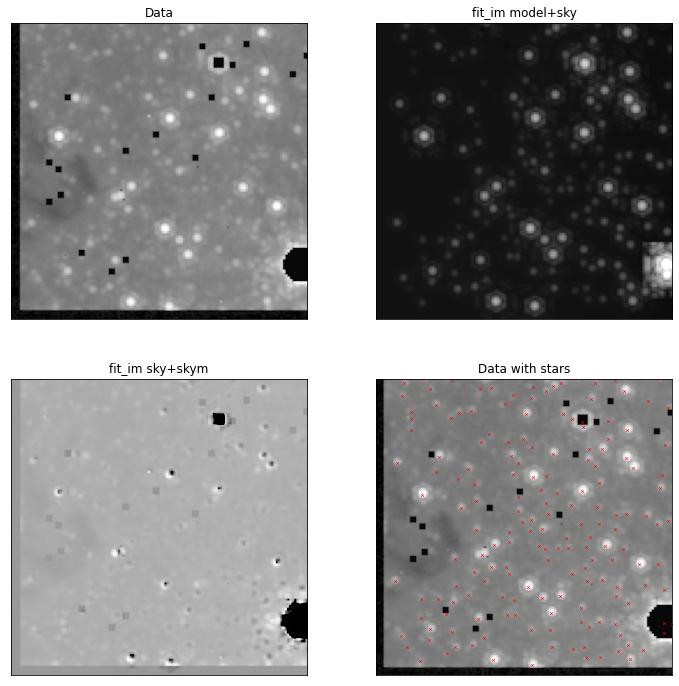

In [48]:
pl.figure(figsize=(12,12))
pl.subplot(2,2,1).imshow(data[:128,:128], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,2,2).imshow(modsky[:128,:128], norm=simple_norm(modsky[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,2,3).imshow((data-modsky)[:128,:128], norm=simple_norm((data-modsky)[:128,:128], stretch='asinh', max_percent=99.95, min_percent=1), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im sky+skym")
pl.subplot(2,2,4).imshow(data[:128,:128], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.subplot(2,2,4).scatter(stars['y'], stars['x'], marker='x', color='r', s=8, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");

Text(0.5, 1.0, 'Fitted model')

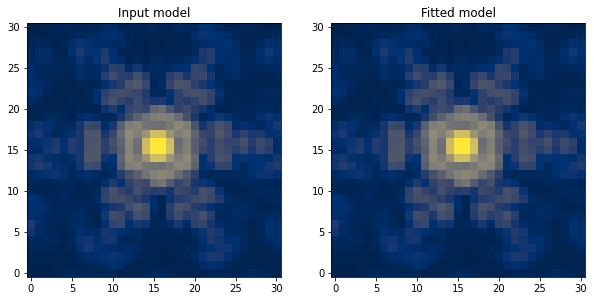

In [49]:
pl.figure(figsize=(10,5))
pl.subplot(1,2,1).imshow(psf_model(30,30), norm=simple_norm(psf_model(30,30), stretch='log'), cmap='cividis')
pl.title("Input model")
pl.subplot(1,2,2).imshow(psf(30,30), norm=simple_norm(psf(30,30), stretch='log'), cmap='cividis')
pl.title("Fitted model")

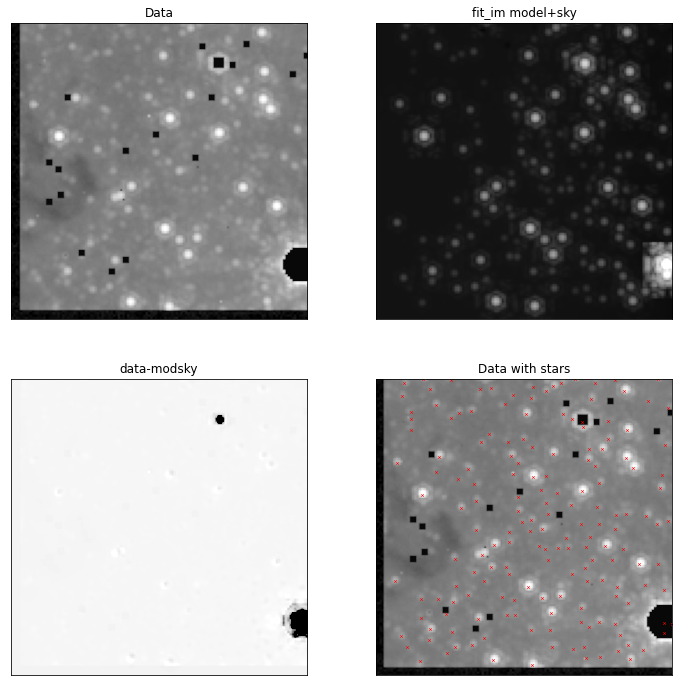

In [50]:
pl.figure(figsize=(12,12))
pl.subplot(2,2,1).imshow(data[:128,:128], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,2,2).imshow(modsky[:128,:128], norm=simple_norm(modsky[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,2,3).imshow((data-modsky)[:128,:128], norm=simple_norm((data-modsky)[:256,:256], stretch='asinh', max_percent=99.5, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("data-modsky")
pl.subplot(2,2,4).imshow(data[:128,:128], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.subplot(2,2,4).scatter(stars['y'], stars['x'], marker='x', color='r', s=8, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");

In [51]:
psf_model(500,500).shape, psf_model(500,500).max()

((31, 31), 0.11279787)

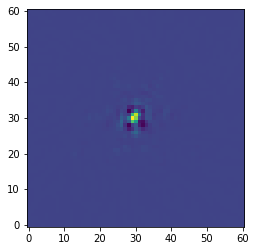

In [52]:
pl.imshow(grid._compute_local_model(500,500)(xx,yy) - grid(xx,yy))

In [53]:
xxx = xx[:,:,None] - np.array([50, 100, 150])[None,None,:]
yyy = yy[:,:,None] - np.array([50, 100, 150])[None,None,:]
grid(xxx, yyy).shape

(61, 61, 3)

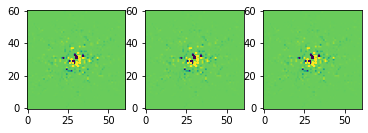

In [54]:
pl.subplot(1,3,1).imshow(grid.evaluate(xxx, yyy, 1, -np.array([50,100,150]), -np.array([50,100,150]))[:,:,0]-grid(xx,yy), norm=simple_norm(np.linspace(-1e-19,1e-19), stretch='asinh'))
pl.subplot(1,3,2).imshow(grid.evaluate(xxx, yyy, 1, -np.array([50,100,150]), -np.array([50,100,150]))[:,:,1]-grid(xx,yy), norm=simple_norm(np.linspace(-1e-19,1e-19), stretch='asinh'))
pl.subplot(1,3,3).imshow(grid.evaluate(xxx, yyy, 1, -np.array([50,100,150]), -np.array([50,100,150]))[:,:,2]-grid(xx,yy), norm=simple_norm(np.linspace(-1e-19,1e-19), stretch='asinh'))

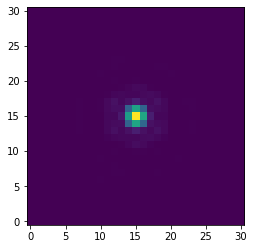

In [55]:
yy, xx = np.indices([31,31])-15
pl.imshow(grid(xx,yy))

In [56]:
yy, xx = np.indices([31,31])-15
grid.evaluate(xx+50.1, yy+100.1, 1, 50.1, 100.1).sum()

0.9054711050205626

In [57]:
yy, xx = np.indices([61,61])-30
grid.evaluate(xx+50.1, yy+100.1, 1, 50.1, 100.1).sum()

0.9364762597002712

In [58]:
grid(-10,10)

5.758480687865504e-05

In [59]:
import numpy

In [60]:
class WrappedPSFModel(crowdsource.psf.SimplePSF):
    """
    wrapper for photutils GriddedPSFModel
    """
    def __init__(self, psfgridmodel, stampsz=19):
        self.psfgridmodel = psfgridmodel
        self.default_stampsz = stampsz

    def __call__(self, col, row, stampsz=None, deriv=False):

        if stampsz is None:
            stampsz = self.default_stampsz

        parshape = numpy.broadcast(col, row).shape
        tparshape = parshape if len(parshape) > 0 else (1,)

        # numpy uses row, column notation
        rows, cols = np.indices((stampsz, stampsz)) - (np.array([stampsz, stampsz])-1)[:, None, None] / 2.

        # explicitly broadcast
        col = np.atleast_1d(col)
        row = np.atleast_1d(row)
        rows = rows[:, :, None] + row[None, None, :]
        cols = cols[:, :, None] + col[None, None, :]

        # photutils seems to use column, row notation
        stamps = grid.evaluate(cols, rows, 1, col, row)
        # it returns something in (nstamps, row, col) shape
        # pretty sure that ought to be (col, row, nstamps) for crowdsource

        if deriv:
            dpsfdrow, dpsfdcol = np.gradient(stamps, axis=(0, 1))
            dpsfdrow = dpsfdrow.T
            dpsfdcol = dpsfdcol.T

        ret = stamps.T
        if parshape != tparshape:
            ret = ret.reshape(stampsz, stampsz)
            if deriv:
                dpsfdrow = dpsfdrow.reshape(stampsz, stampsz)
                dpsfdcol = dpsfdcol.reshape(stampsz, stampsz)
        if deriv:
            ret = (ret, dpsfdcol, dpsfdrow)

        return ret


    def render_model(self, col, row, stampsz=None):
        """
        this function likely does nothing?
        """
        if stampsz is not None:
            self.stampsz = stampsz

        rows, cols = np.indices(self.stampsz, dtype=float) - (np.array(self.stampsz)-1)[:, None, None] / 2.

        return self.psfgridmodel.evaluate(cols, rows, 1, col, row).T.squeeze()


In [61]:
wrapmod =  WrappedPSFModel(grid, 31)
wrapmod(100, 100).shape

(31, 31)

In [62]:
results2  = fit_im(data, wrapmod, weight=np.ones_like(data)*5,
                   #psfderiv=np.gradient(-psf_initial[0].data),
                   nskyx=0, nskyy=0, refit_psf=False, verbose=True)
stars, modsky, skymsky, psf = results

Starting subregion iterations
Subregion iteration 0 starting; dt=0.0017414093017578125
titer=0
Extension None, iteration  1, found  67429 sources;  115 close and 11640 faint sources removed.
Starting subregion iterations
Subregion iteration 0 starting; dt=0.001613616943359375


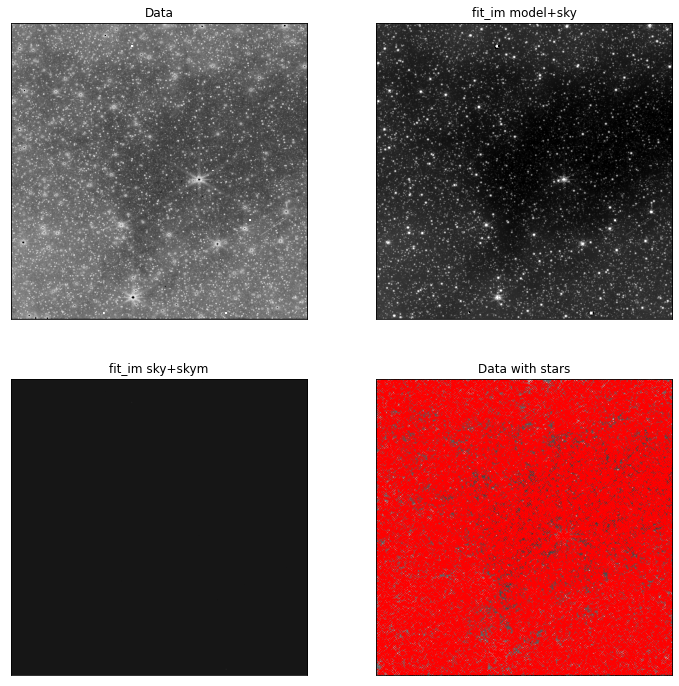

In [63]:
pl.figure(figsize=(12,12))
pl.subplot(2,2,1).imshow(data, norm=simple_norm(data, stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,2,2).imshow(modsky, norm=simple_norm(modsky, stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,2,3).imshow((data-modsky), norm=simple_norm((data-modsky), stretch='asinh'), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im sky+skym")
pl.subplot(2,2,4).imshow(data, norm=simple_norm(data, stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.subplot(2,2,4).scatter(stars['y'], stars['x'], marker='x', color='r', s=5, linewidth=0.5)
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");

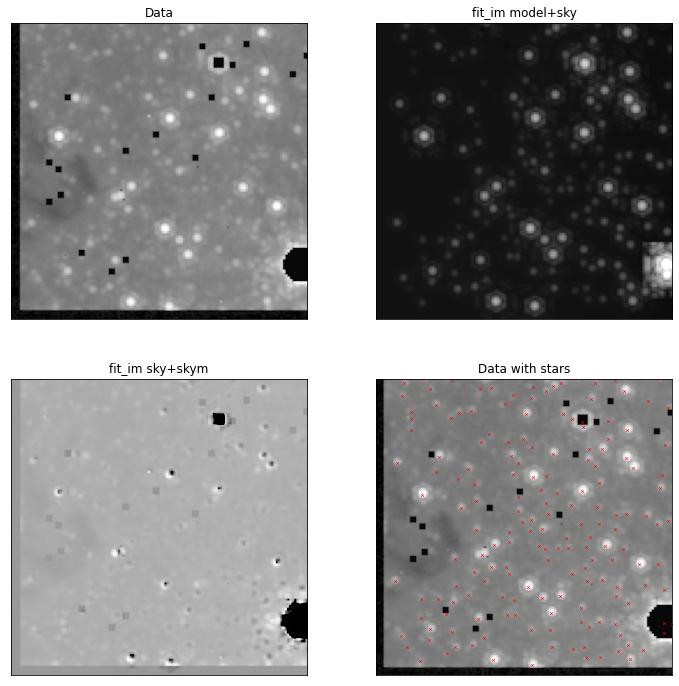

In [64]:
pl.figure(figsize=(12,12))
pl.subplot(2,2,1).imshow(data[:128,:128], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,2,2).imshow(modsky[:128,:128], norm=simple_norm(modsky[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,2,3).imshow((data-modsky)[:128,:128], norm=simple_norm((data-modsky)[:128,:128], stretch='asinh', max_percent=99.95, min_percent=1), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im sky+skym")
pl.subplot(2,2,4).imshow(data[:128,:128], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.subplot(2,2,4).scatter(stars['y'], stars['x'], marker='x', color='r', s=8, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("Data with stars");

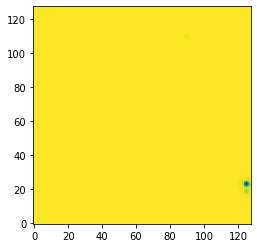

In [65]:
pl.imshow((data-modsky)[:128, :128])